<a id='main' name="main"></a>
# Regression Analysis on USA House Dataset

Date: 2023.03.12  
Author: © 2023 Zeynalov Hasan

In this work:
1. [Data Preperation and Understanting.](#1)
2. [Data Visulizations](#2)
3. [Modelling on 7 Regression Models](#3)
4. [Comparing Evaulation Metrics](#4)
5. [Checking for all Assumptions in the best model](#5)

Using the open data from: 
* You can find the data from the Kaggle

<a id='1' name='1'></a>
# Data Preperation and Understanting

In [100]:
#enable all warnings in this notebook
import warnings
warnings.filterwarnings('ignore')
#import all libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.pandas
import numpy as np
from scipy.stats import norm
from scipy import stats
from yellowbrick.regressor import ResidualsPlot

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet,SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error

In [25]:
df = pd.read_csv('USA_Housing (1).csv')
df.head()

,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price,Address
0,79545.458574,5.682861,7.009188,4.09,23086.800503,1.059034e+06,"208 Michael Ferry Apt. 674\nLaurabury, NE 3701..."
1,79248.642455,6.002900,6.730821,3.09,40173.072174,1.505891e+06,"188 Johnson Views Suite 079\nLake Kathleen, CA..."
2,61287.067179,5.865890,8.512727,5.13,36882.159400,1.058988e+06,"9127 Elizabeth Stravenue\nDanieltown, WI 06482..."
3,63345.240046,7.188236,5.586729,3.26,34310.242831,1.260617e+06,USS Barnett\nFPO AP 44820
4,59982.197226,5.040555,7.839388,4.23,26354.109472,6.309435e+05,USNS Raymond\nFPO AE 09386


In [26]:
#checking for null values
df.isnull().any().sum()

0

In [27]:
#checking for duplicate values
df.duplicated().sum()

0

In [28]:
df.columns

Index(['Avg. Area Income', 'Avg. Area House Age', 'Avg. Area Number of Rooms',
       'Avg. Area Number of Bedrooms', 'Area Population', 'Price', 'Address'],
      dtype='object')

In [29]:
#changing all feature's name
df.rename({'Avg. Area Income':'avg_income',
          'Avg. Area House Age':'avg_age',
          'Avg. Area Number of Rooms':'avg_number_of_rooms',
          'Avg. Area Number of Bedrooms':'avg_number_of_bedrooms',
          'Area Population':'area_population',
          'Price':'price',
          'Address':'address'},inplace = True,axis=1)

In [30]:
df.shape

(5000, 7)

In [32]:
df['address'].nunique()
#deleting adress because it is the unique value
df.drop('address',axis=1,inplace=True)

In [33]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
avg_income,5000.0,6.858311e+04,10657.991214,17796.631190,61480.562388,6.880429e+04,7.578334e+04,1.077017e+05
avg_age,5000.0,5.977222e+00,0.991456,2.644304,5.322283,5.970429e+00,6.650808e+00,9.519088e+00
avg_number_of_rooms,5000.0,6.987792e+00,1.005833,3.236194,6.299250,7.002902e+00,7.665871e+00,1.075959e+01
avg_number_of_bedrooms,5000.0,3.981330e+00,1.234137,2.000000,3.140000,4.050000e+00,4.490000e+00,6.500000e+00
area_population,5000.0,3.616352e+04,9925.650114,172.610686,29403.928702,3.619941e+04,4.286129e+04,6.962171e+04
price,5000.0,1.232073e+06,353117.626581,15938.657923,997577.135049,1.232669e+06,1.471210e+06,2.469066e+06


In [34]:
#checking for skewness
for cols in df.columns:
    print(f"{cols}:{df[cols].skew()}")

avg_income:-0.03371997540427547
avg_age:-0.007213872365817422
avg_number_of_rooms:-0.04099591018006096
avg_number_of_bedrooms:0.37624039721554303
area_population:0.0506496815321505
price:-0.0027180649335593852


<a id='2' name='2'></a>
# Data Visualizations 

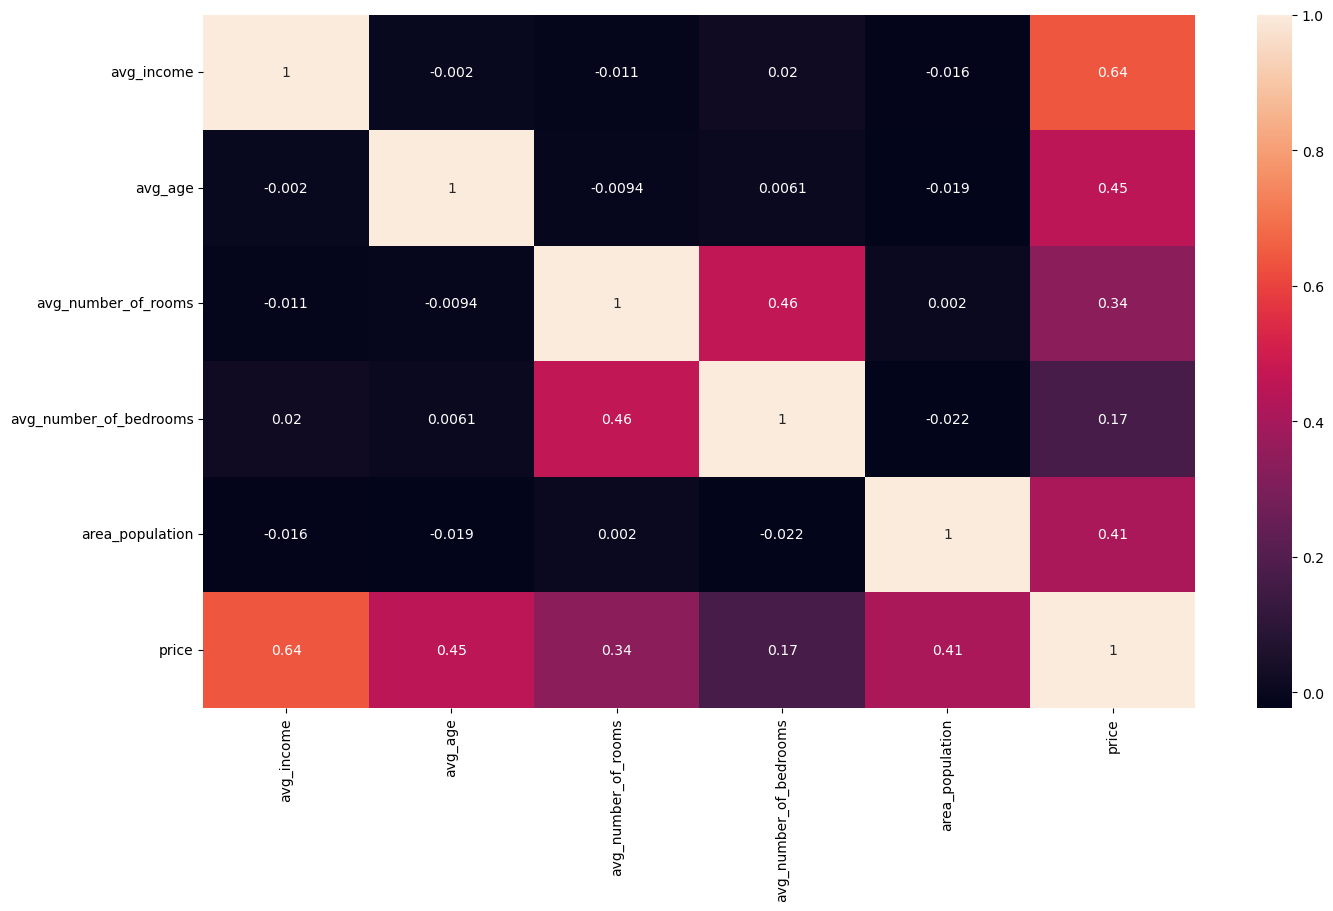

In [35]:
#correlation to see how features affect to the target(price)
plt.figure(figsize=(16,9))
sns.heatmap(df.corr(),annot=True)
plt.show()

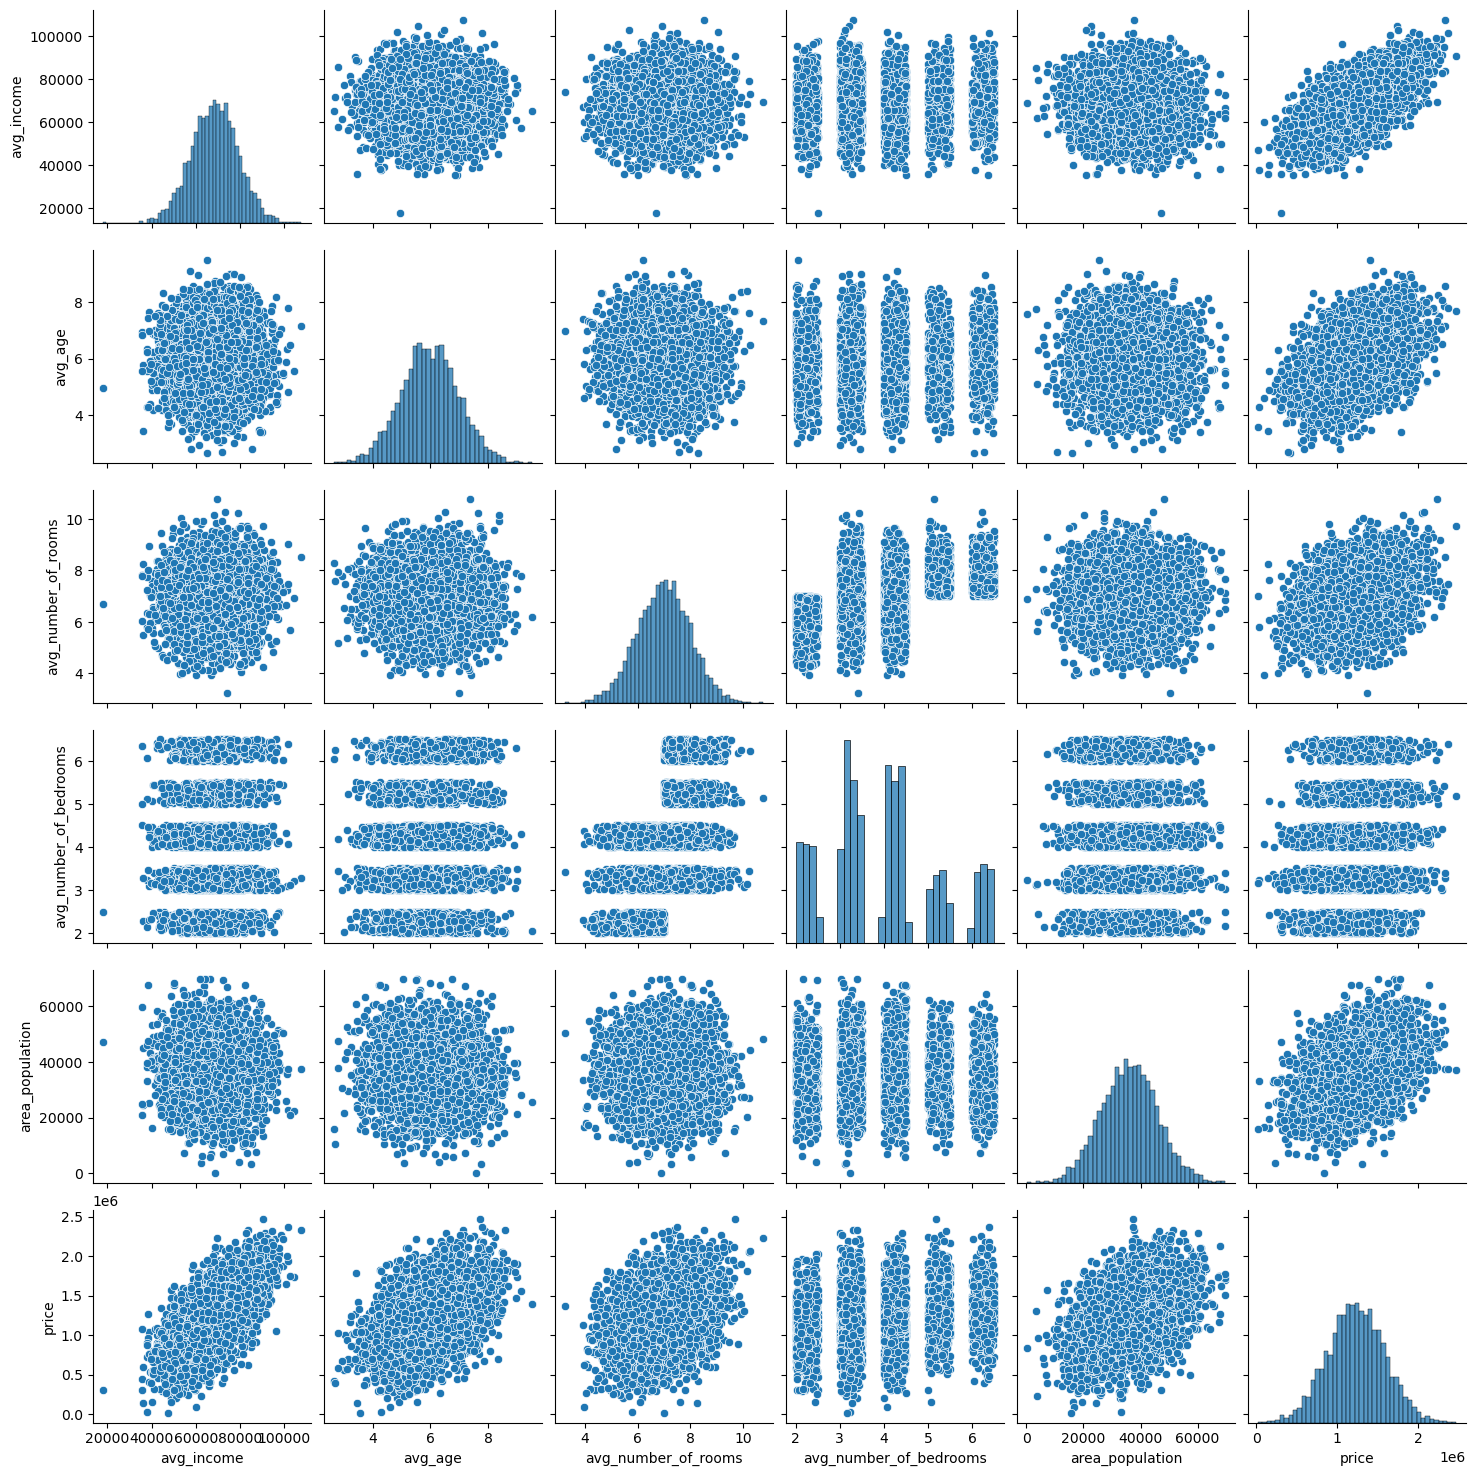

In [86]:
#pairplot
sns.pairplot(df)
plt.show()

<a id='3' name='3'></a>
# Modelling on 7 Regression Models

__I have choosen 7 regression models:__
1. Linear Regression.
2. Support Vector Machine.
3. Ridge Regression.
4. LASSO Regression
5. Elastic net
6. Stochastic Gradient Descent.
7. Random Forest Regression.

In [38]:
#choosing dependent and target value
y = df.iloc[:,5:6]
X = df.drop('price',axis=1).values
#train test splitting
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [42]:
#validation score
def cross_val(model):
    pred = cross_val_score(model, X, y, cv=10)
    return pred.mean()
#evaulation metrics
def print_evaluate(true, predicted):  
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    print('MAE:', round(mae,2))
    print('MSE:', round(mse,2))
    print('RMSE:', round(rmse),2)
    print('R2 Square:', round(r2_square,2))

In [43]:
#feature scalling after modelling
pipeline = Pipeline(steps=[
    ('stad_scaler',StandardScaler())
])
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.fit_transform(X_test)

# 1.Linear Regression

In [44]:
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [45]:
lr_pred_test = lr.predict(X_test)
lr_pred_train = lr.predict(X_train)

In [46]:
print(f"Intercept:{lr.intercept_}")

Intercept:[1229576.99256009]


In [47]:
coeff_df = pd.DataFrame(lr.coef_.reshape(-1,1),
             index=['avg_income','avg_age','avg_number_of_rooms','avg_number_of_bedrooms','area_population'],
             columns=['Coeffisient'])
coeff_df

,Coeffisient
avg_income,231741.876652
avg_age,163580.776566
avg_number_of_rooms,120724.771387
avg_number_of_bedrooms,2992.449135
area_population,152235.900097


In [48]:
#evaluation metrics on test for linear regression
print_evaluate(y_test,lr_pred_test)

MAE: 81539.13
MSE: 10325225811.76
RMSE: 101613 2
R2 Square: 0.92


In [49]:
cross_val(LinearRegression())

0.9173792621537272

# 2.Support Vector Machine

In [50]:
svr = SVR(kernel='rbf',C=100000,epsilon=0.001)
svr.fit(X_train,y_train)

SVR(C=100000, epsilon=0.001)

In [51]:
svr_pred = svr.predict(X_test)

In [52]:
print_evaluate(y_test,svr_pred)

MAE: 88297.24
MSE: 12427506377.58
RMSE: 111479 2
R2 Square: 0.9


In [53]:
warnings.filterwarnings('ignore')
cross_val(svr)

0.5796548954995769

# 3.Ridge Regression

In [54]:
ridge_model = Ridge(alpha=100,solver='cholesky',tol = 0.0001,random_state=42)
ridge_model.fit(X_train,y_train)

Ridge(alpha=100, random_state=42, solver='cholesky')

In [55]:
ridge_predict = ridge_model.predict(X_test)
print_evaluate(ridge_predict,y_test)

MAE: 81413.8
MSE: 10286536251.29
RMSE: 101423 2
R2 Square: 0.91


In [56]:
cross_val(ridge_model)

0.9172034646603962

# 4.LASSO Regression

In [57]:
lasso_model = Lasso(alpha=0.1, 
              selection='random',
              random_state=42)
lasso_model.fit(X_train,y_train)

Lasso(alpha=0.1, random_state=42, selection='random')

In [58]:
lasso_predict = lasso_model.predict(X_test)
print_evaluate(lasso_predict,y_test)

MAE: 81539.12
MSE: 10325222946.74
RMSE: 101613 2
R2 Square: 0.91


In [59]:
cross_val(lasso_model)

0.9173792622618342

# 5.Elastic Net

In [60]:
elastic_model = ElasticNet(alpha=0.1, l1_ratio=0.9, selection='random', random_state=42)
elastic_model.fit(X_train,y_train)

ElasticNet(alpha=0.1, l1_ratio=0.9, random_state=42, selection='random')

In [61]:
elastic_predict = elastic_model.predict(X_test)
print_evaluate(elastic_predict,y_test)

MAE: 81410.44
MSE: 10290891638.22
RMSE: 101444 2
R2 Square: 0.91


In [62]:
cross_val(elastic_model)

0.9173428580923486

# 6.Stochastic Gradient Descent

In [63]:
sgd = SGDRegressor(n_iter_no_change=250, penalty=None, eta0=0.0001, max_iter=100000)
sgd.fit(X_train,y_train)

SGDRegressor(eta0=0.0001, max_iter=100000, n_iter_no_change=250, penalty=None)

In [64]:
sgd_predict = sgd.predict(X_test)
print_evaluate(elastic_predict,y_test)

MAE: 81410.44
MSE: 10290891638.22
RMSE: 101444 2
R2 Square: 0.91


In [65]:
cross_val(sgd)

-2.1238168908787165e+20

# 7.Random Forest Regressor

In [66]:
rfr = RandomForestRegressor()
rfr.fit(X_train,y_train)

RandomForestRegressor()

In [67]:
rfr_predict = rfr.predict(X_test)
print_evaluate(rfr_predict,y_test)

MAE: 94786.31
MSE: 14508355560.11
RMSE: 120451 2
R2 Square: 0.86


In [68]:
cross_val(rfr)

0.8848846696867263

<a id='4' name='4'></a>
# Comparing Evaulation Metrics

In [69]:
#return all evaluation metrics
def compare_metrics(predicted,actual):
    mae = mean_absolute_error(predicted,actual)
    mse = mean_absolute_error(predicted,actual)
    rmse = np.sqrt(mean_squared_error(predicted,actual))
    r2 = r2_score(predicted,actual)
    return mae,mse,rmse,r2

In [70]:
#creating dataframe to show best model
#setting column names
columns = ['Model','MAE','MSE','RMSE','R2','Cross Validation Score']
#creating dataframe
#linear regression
final_df = pd.DataFrame(data=[['Linear',*compare_metrics(y_test,lr_pred_test),cross_val(LinearRegression())]],
             columns = columns)
#support vector machine
df2 = pd.DataFrame(data=[['SVM',*compare_metrics(y_test,svr_pred),cross_val(svr)]],
             columns = columns)
final_df = final_df.append(df2,ignore_index=True)
#ridge regression
df3 = pd.DataFrame(data=[['Ridge',*compare_metrics(y_test,ridge_predict),cross_val(ridge_model)]],
             columns = columns)
final_df = final_df.append(df3,ignore_index=True)

#lasso regression
df4 = pd.DataFrame(data=[['Lasso',*compare_metrics(y_test,lasso_predict),cross_val(lasso_model)]],
             columns = columns)
final_df = final_df.append(df4,ignore_index=True)
#elastic net
df5 = pd.DataFrame(data=[['Elastic net',*compare_metrics(y_test,elastic_predict),cross_val(elastic_model)]],
             columns = columns)
final_df = final_df.append(df5,ignore_index=True)
#sgd
df6 = pd.DataFrame(data=[['SGD',*compare_metrics(y_test,sgd_predict),cross_val(sgd)]],
             columns = columns)
final_df = final_df.append(df6,ignore_index=True)

#random forest
df7 = pd.DataFrame(data=[['Random Forest',*compare_metrics(y_test,rfr_predict),cross_val(rfr)]],
             columns = columns)
final_df = final_df.append(df7,ignore_index=True)

In [71]:
final_df

,Model,MAE,MSE,RMSE,R2,Cross Validation Score
0,Linear,81539.130729,81539.130729,101613.118305,0.916077,9.173793e-01
1,SVM,88297.239716,88297.239716,111478.726121,0.898990,5.796549e-01
2,Ridge,81413.795284,81413.795284,101422.562831,0.916392,9.172035e-01
3,Lasso,81539.120237,81539.120237,101613.104208,0.916077,9.173793e-01
4,Elastic net,81410.435672,81410.435672,101444.032048,0.916356,9.173429e-01
5,SGD,81539.129122,81539.129122,101613.118541,0.916077,-9.239987e+19
6,Random Forest,94786.310957,94786.310957,120450.635366,0.882077,8.842087e-01


In [72]:
#sorting dataframe by r2 score.the most imoortant metric in the regression models
final_df.sort_values(by='R2',ascending = False)

,Model,MAE,MSE,RMSE,R2,Cross Validation Score
2,Ridge,81413.795284,81413.795284,101422.562831,0.916392,9.172035e-01
4,Elastic net,81410.435672,81410.435672,101444.032048,0.916356,9.173429e-01
3,Lasso,81539.120237,81539.120237,101613.104208,0.916077,9.173793e-01
0,Linear,81539.130729,81539.130729,101613.118305,0.916077,9.173793e-01
5,SGD,81539.129122,81539.129122,101613.118541,0.916077,-9.239987e+19
1,SVM,88297.239716,88297.239716,111478.726121,0.898990,5.796549e-01
6,Random Forest,94786.310957,94786.310957,120450.635366,0.882077,8.842087e-01


In [73]:
#sorting dataframe by validate score
final_df.sort_values(by='Cross Validation Score',ascending = False)

,Model,MAE,MSE,RMSE,R2,Cross Validation Score
3,Lasso,81539.120237,81539.120237,101613.104208,0.916077,9.173793e-01
0,Linear,81539.130729,81539.130729,101613.118305,0.916077,9.173793e-01
4,Elastic net,81410.435672,81410.435672,101444.032048,0.916356,9.173429e-01
2,Ridge,81413.795284,81413.795284,101422.562831,0.916392,9.172035e-01
6,Random Forest,94786.310957,94786.310957,120450.635366,0.882077,8.842087e-01
1,SVM,88297.239716,88297.239716,111478.726121,0.898990,5.796549e-01
5,SGD,81539.129122,81539.129122,101613.118541,0.916077,-9.239987e+19


##### The best model are Lasso,Linear,Elastic Net and Ridge with the one of the highest r2 and validation score 

# Hyperparameter Tuning with Randomized Search on the best model

##### let's get Hyperparameter Tune on the one of the best model,Ridge Regression

<div class="alert alert-block alert-success">
<b>With the Randomized Search:</b>
</div>

In [74]:
parameters = {'alpha':[20,50,70,100],
             'solver':['svd','cholesky','lbfgs','sparse_cg'],
             'tol':[0.00001,0.0001,0.001,0.01]}

In [75]:
rs = RandomizedSearchCV(estimator=Ridge(),
                   param_distributions=parameters,
                   cv=5)

In [76]:
rs.fit(X_train,y_train)

RandomizedSearchCV(cv=5, estimator=Ridge(),
                   param_distributions={'alpha': [20, 50, 70, 100],
                                        'solver': ['svd', 'cholesky', 'lbfgs',
                                                   'sparse_cg'],
                                        'tol': [1e-05, 0.0001, 0.001, 0.01]})

In [77]:
best_score = rs.best_score_

In [78]:
print(f'The Score Improved {r2_score(ridge_predict,y_test)} to {best_score} using RandomizedSearch')

The Score Improved 0.908252633568023 to 0.9173854212778936 using RandomizedSearch


In [79]:
rs.best_params_

{'tol': 0.01, 'solver': 'sparse_cg', 'alpha': 20}

<div class="alert alert-block alert-success">
<b>With the Grid Search:</b>
</div>

In [80]:
gs = GridSearchCV(estimator=Ridge(),
                param_grid=parameters,
                   cv=5)

In [81]:
gs.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [20, 50, 70, 100],
                         'solver': ['svd', 'cholesky', 'lbfgs', 'sparse_cg'],
                         'tol': [1e-05, 0.0001, 0.001, 0.01]})

In [82]:
gs_b_score = gs.best_score_

In [83]:
gs.best_params_

{'alpha': 20, 'solver': 'sparse_cg', 'tol': 0.01}

In [84]:
print(f'The Score Improved {r2_score(ridge_predict,y_test)} to {gs_b_score} using GridSearchCV')

The Score Improved 0.908252633568023 to 0.9173854212778936 using GridSearchCV


<a id='5' name='5'></a>
# Checking for all Assumptions in the best model

### There are 5 Assumptions in the regression model to ensure that the model is valid and reliable.
1. Linearity
2. Normality
3. Homoscedasticity
4. Independence
5. Multicollinearity

### To check these assumptions, you can use various statistical tests and visualizations. Some commonly used tests and visualizations include:

1. Scatter plots: To check for linearity and homoscedasticity.

2. Histograms and normal probability plots: To check for normality.

3. Residual plots: To check for homoscedasticity and independence.

4. Correlation matrix: To check for multicollinearity.

<div class="alert alert-block alert-danger">
<b>Linearity:</b>
</div>

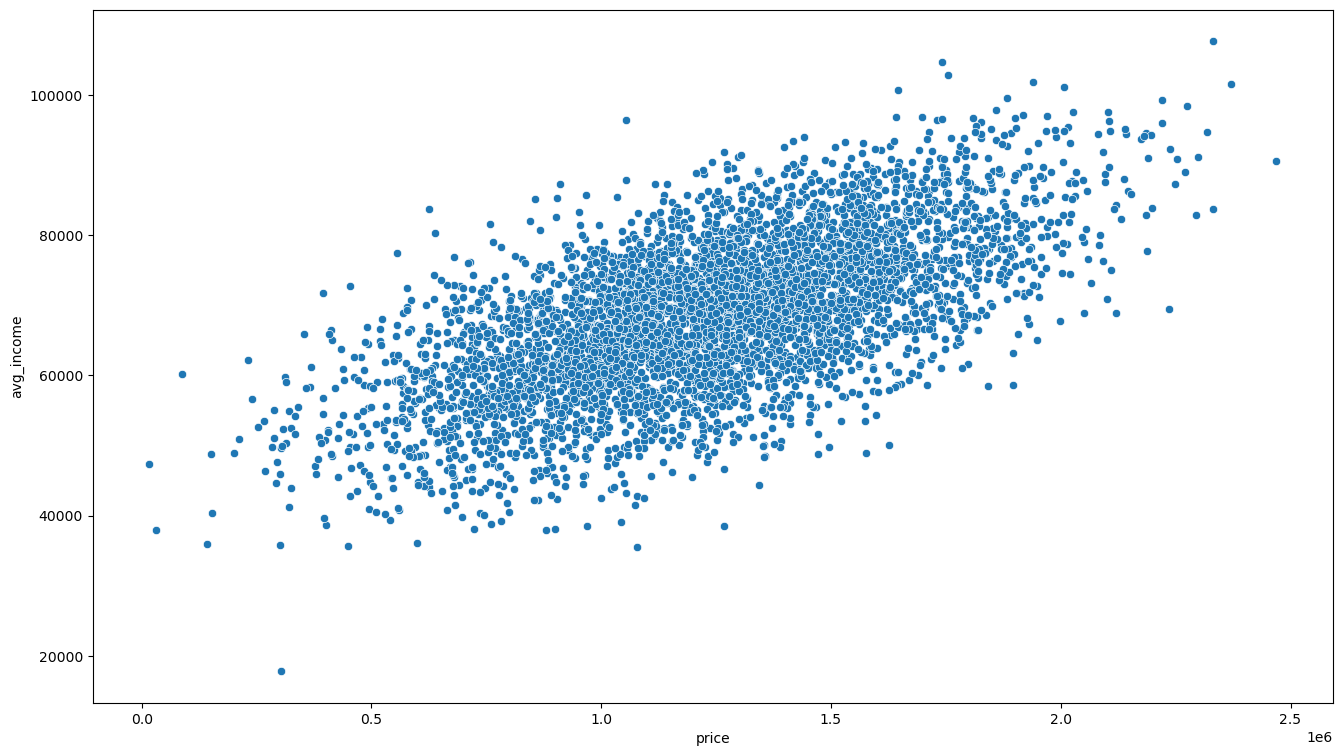

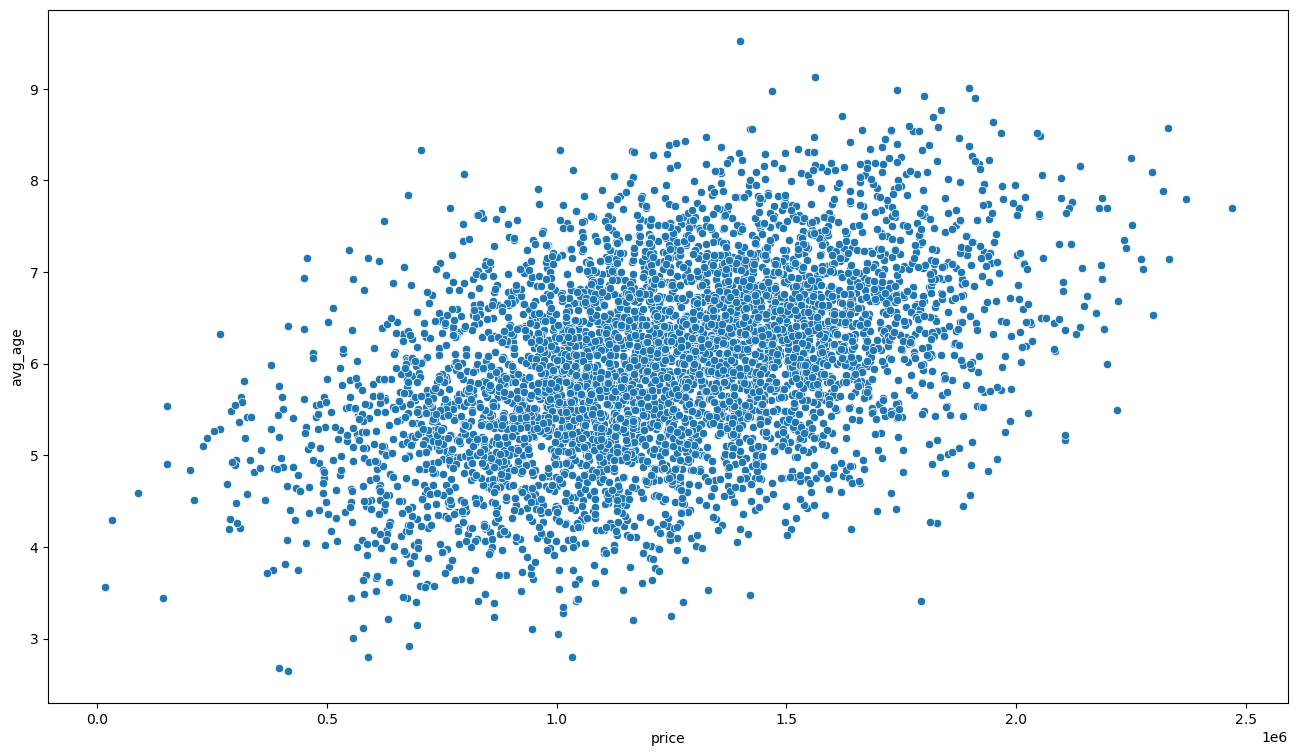

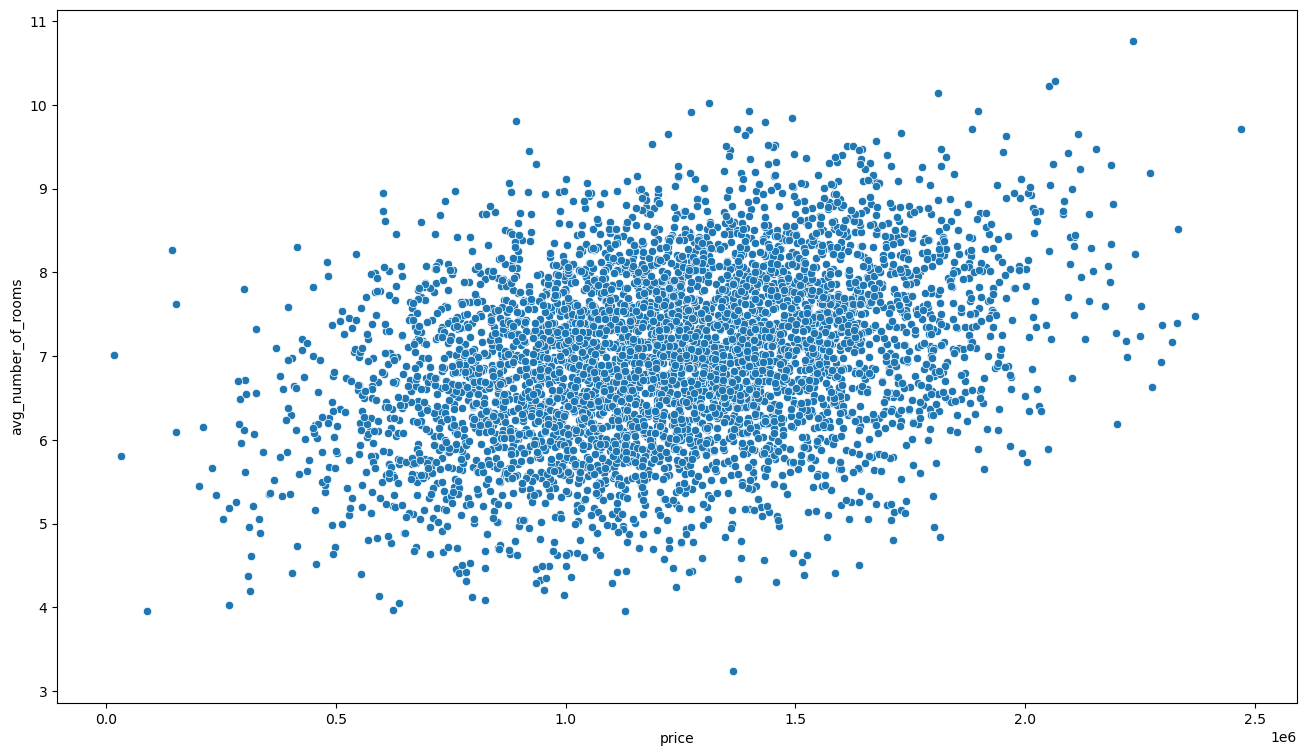

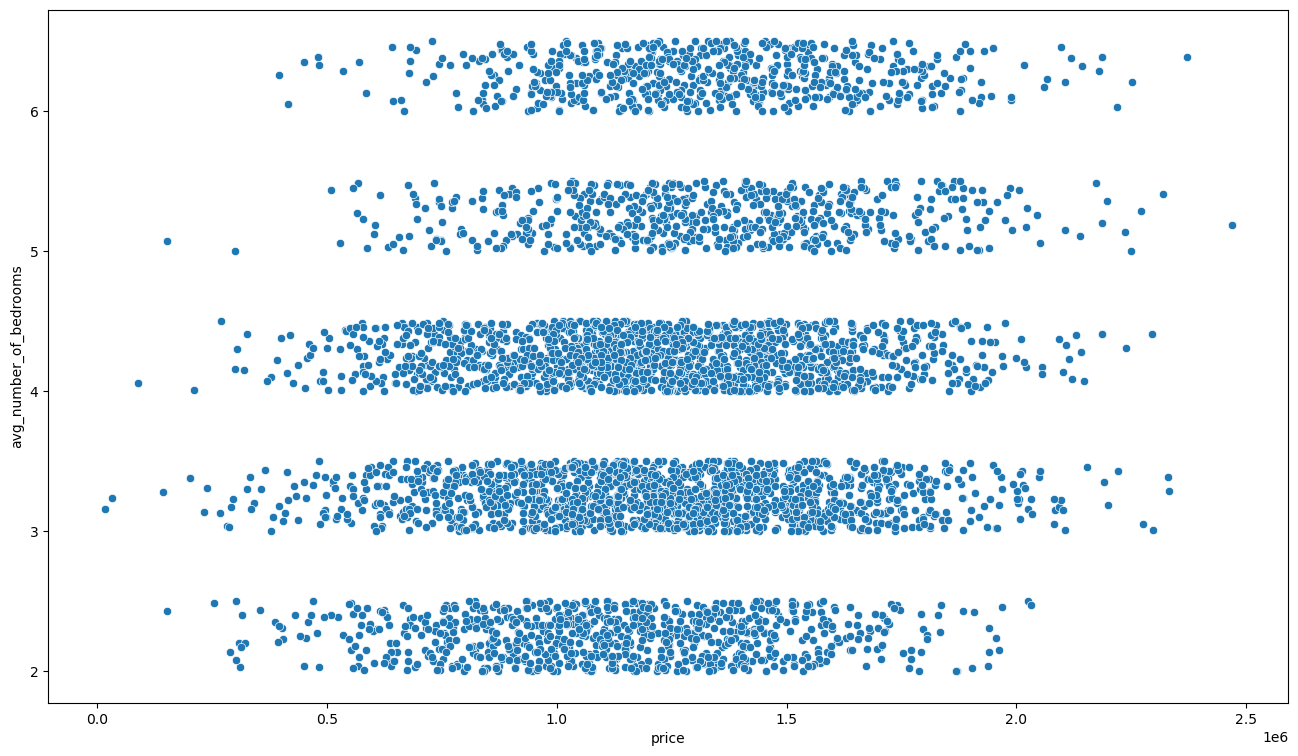

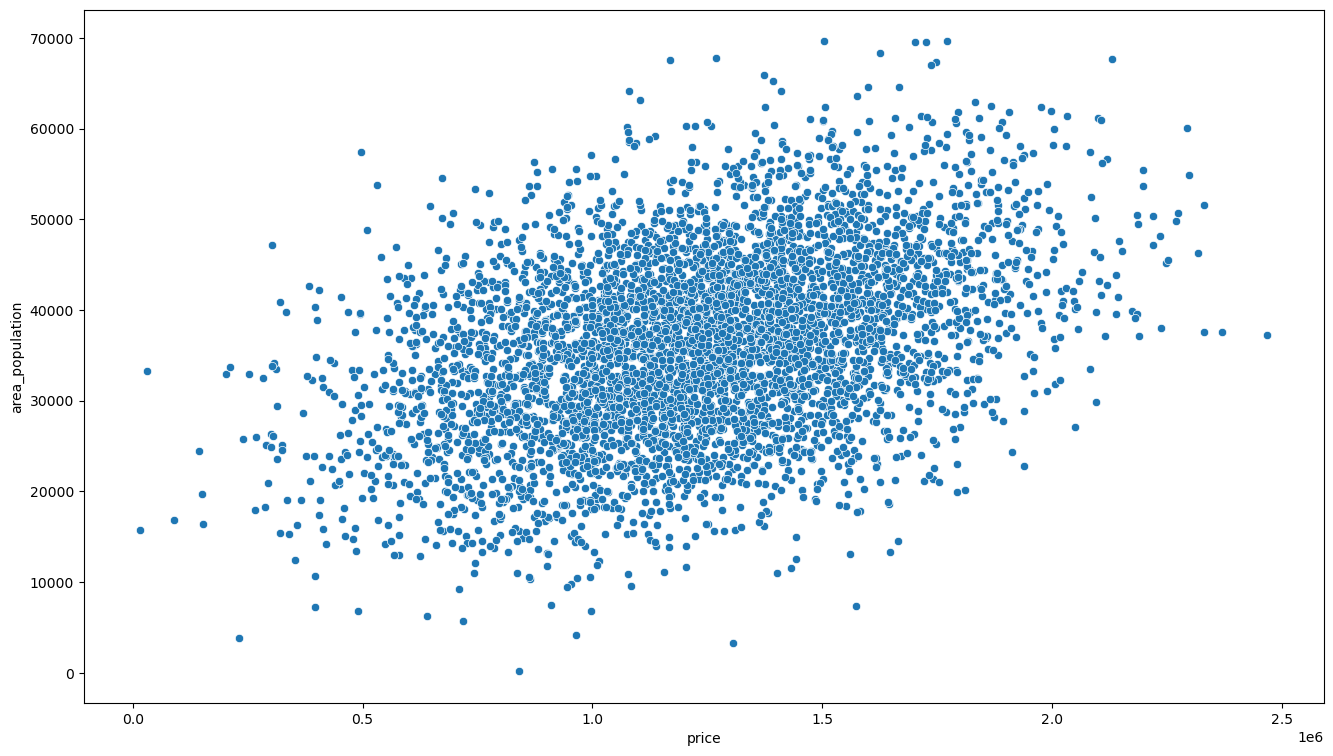

In [85]:
#The relationship between the independent variable(s) and the dependent variable should be linear. 
#scatter plot
for cols in df.columns:
    if cols == 'price':
        continue
    plt.figure(figsize=(16,9))
    sns.scatterplot(data = df,x = 'price',y = cols)
    plt.show()
#done

<div class="alert alert-block alert-danger">
<b>Normality:</b> 
</div>

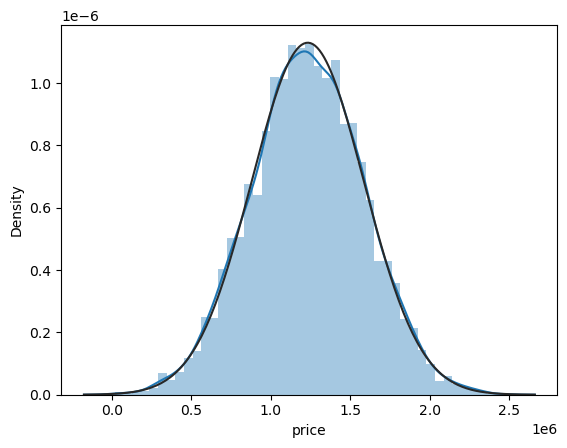

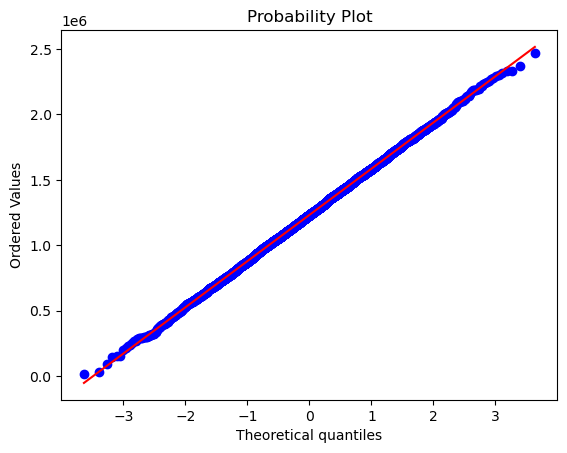

In [92]:
#The residuals (the difference between the predicted values and the actual values) should be normally distributed
sns.distplot(df['price'], fit=norm);
fig = plt.figure()
res = stats.probplot(df['price'], plot=plt)
#done

<div class="alert alert-block alert-danger">
<b>Homoscedasticity:</b>
</div>

In [99]:
#pip install yellowbrick

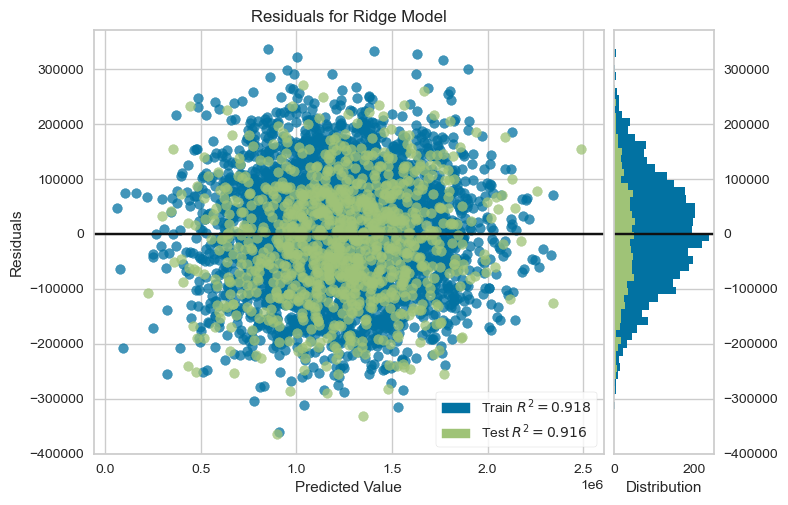

In [105]:
#The variance of the residuals should be constant across all levels of the independent variables.
model = Ridge()
visualizer = ResidualsPlot(model)
visualizer.fit(X_train,y_train)
score = visualizer.score(X_test,y_test)
# Draw/show/poof the data
g = visualizer.poof() 
#done

<div class="alert alert-block alert-danger">
<b>Multicollinearity:</b>
</div>

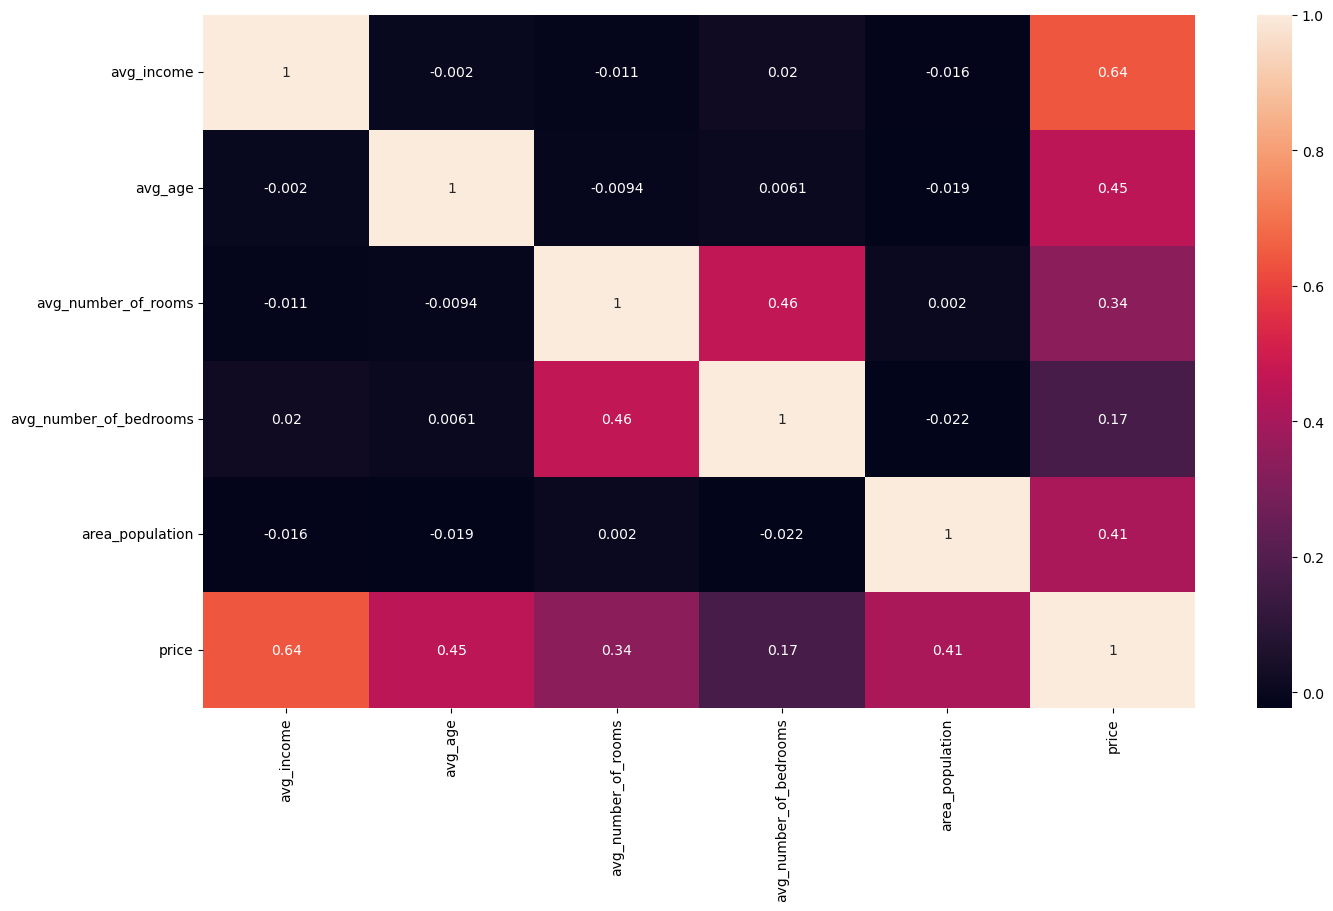

In [87]:
# If there are multiple independent variables in the model, they should not be highly correlated with each other.
plt.figure(figsize=(16,9))
sns.heatmap(df.corr(),annot=True)
plt.show()
#not done
#between avg_number_of_rooms and avg_number_of_bedrooms has higly correlation,so we had to delete one of them